---
Creation date: 12 of August, 2024

Modification date: 12 of August, 2024

---

In [1]:
from pyvo.dal import tap  # Useful for interaction with online astronomical data services, allows querying databases
from astropy.coordinates import SkyCoord  # Module for handling astronomical coordinate systems

import requests # Library for making HTTP requests

import os  # Library for interacting with the operating system
import cgi  # Library for parsing headers
import pandas as pd  # Library for data manipulation and analysis
from fastparquet import write  # Useful for writing Parquet files - a columnar storage format

import coronagraph as cg  # Module for simulating the performance of coronagraphs

from astropy.io import fits as pyfits  # Module for reading and writing FITS files
import numpy as np  # Library for advanced numerical operations
import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations

from matplotlib.animation import FuncAnimation, PillowWriter  # Libraries for creating animations

from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN

from sklearn.metrics import mean_squared_error

import seaborn as sns  



ESO_TAP_OBS = "http://archive.eso.org/tap_obs" # For the ESO TAP service
ESO_TAP_CAT = "https://archive.eso.org/tap_cat" # For the ESO TAP service
tapobs = tap.TAPService(ESO_TAP_OBS) # For the ESO TAP service
tapobs2 = tap.TAPService(ESO_TAP_CAT) # For the ESO TAP service



---
## <a id='query'>1. Query in RV Catalog</a>

**Query and send the ADQL query to the ESO TAP service and get the resulting table**


In this step, we execute the ADQL query and obtain the results from the ESO TAP service. The search query is configured to return a maximum of 10 records, so the result table (`res`) will contain up to 10 entries. For demonstration purposes, the results are displayed in a table format (`resT`). For simplicity, only the first 3 rows of the output are shown.




In [79]:
### Selecting everything SNR>200 

query_HARPS_RVCAT = """SELECT *
                    FROM HARPS_RVCAT_V1
                    WHERE main_id_simbad = '* bet Pic'
                    AND drs_snr > 0
                    ORDER BY mjd_obs ASC
                    """
#200 - 400
#ORDER BY mjd_obs ASC
res = tapobs2.search(query=query_HARPS_RVCAT, maxrec=100000) #Maximum records to return
resT=res.to_table()
a=len(resT)
print("Num matching datasets: %d" % (a))

Num matching datasets: 9093


## Histogram of SNR

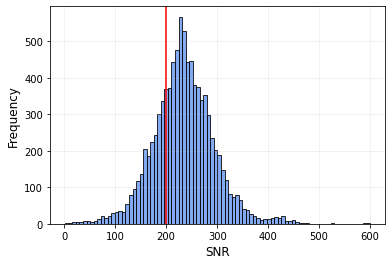

In [80]:
plt.hist(resT['drs_snr'], bins='auto',edgecolor='black',color='cornflowerblue',alpha=0.8)
plt.xlabel('SNR',size=12)
plt.ylabel('Frequency',size=12)
plt.axvline(x=200,c='red')
plt.grid(alpha=0.2)
plt.savefig(parent_dir+'/my_notebooks/Hist_SNR.jpg', dpi=700,bbox_inches='tight')

In [2]:
### Selecting everything SNR>200 

query_HARPS_RVCAT = """SELECT *
                    FROM HARPS_RVCAT_V1
                    WHERE main_id_simbad = '* bet Pic'
                    AND drs_snr > 200
                    ORDER BY mjd_obs ASC
                    """
#200 - 400
#ORDER BY mjd_obs ASC
res = tapobs2.search(query=query_HARPS_RVCAT, maxrec=100000) #Maximum records to return
resT=res.to_table()
a=len(resT)
print("Num matching datasets: %d" % (a))

Num matching datasets: 6676


---

## <a id='downloading_data'>2. Preprocessing and downloading the Data </a>

### <a id='cutouts'>2.1 Defining Spectral Cutouts Prior to Data Download</a>

In this section, we first create cutouts of specific spectral regions before downloading the data. For this analysis, we focus on selecting files that fall within a defined wavelength range (`wave_range`) to examine a region of interest, specifically around the CaII K line. To keep things organized, we will create a directory to store the files we download.


In [3]:
# Specify the parent directory; update this to match your own directory structure
parent_dir='/Users/usuario/Desktop/ESRP2024/Project/notebooks/' 

wave_range=[350,450] #range of wavelengths in nm 

# Create the target folder path based on the wavelength range to save the files
folder_path = os.path.join(parent_dir, 'TARGET_'+str(wave_range[0])+'-'+str(wave_range[1]))

# Check if the folder already exists, and create it if it does not
if os.path.exists(folder_path):
    print('The folder already exists')
else:
    os.mkdir(folder_path)
    print('Folder successfully created')

The folder already exists


### <a id='downloading_data_process'>2.2 Downloading the Data</a>

Previoulsy, we define functions to handle the retrieval and storage of FITS files from HTTP responses. 

In [4]:
def getDispositionFilename( response ): #get the filename from the header
    """Get the filename from the Content-Disposition in the response's http header"""
    contentdisposition = response.headers.get('Content-Disposition')
    if contentdisposition == None:
        return None
    value, params = cgi.parse_header(contentdisposition)
    filename = params["filename"]
    return filename

def writeFile( response, folder_path ): #write content of file on disk
    """Write on disk the retrieved file specifying a folder path"""
    if response.status_code == 200:
        # The ESO filename can be found in the response header
        filename = getDispositionFilename( response )
        # Let's write on disk the downloaded FITS spectrum using the ESO filename:
        full_path = os.path.join(folder_path, filename)
        with open(full_path, 'wb') as f:
            f.write(response.content)
        return filename 

We download FITS files from the [ESO Data Portal](https://dataportal.eso.org/dataportal_new/file/) using a specified base URL and save them to a designated folder. The process involves iterating through the query results to download and store each file on disk. 

In [ ]:
#Base URL for downloading files from the ESO data portal
beg='https://dataportal.eso.org/dataportal_new/' 
notfiles=[]

for k in range(a): # Iterate through the number of matching datasets
 
    # Construct the full URL for the file download
    filebeg = f"{beg}soda/sync?ID={resT[k]['adp_dpid']}&PREFIX={wave_range[0]}-{wave_range[1]}&BAND={wave_range[0]}e-9+{wave_range[1]}e-9"
    response=requests.get(filebeg)
    filename = writeFile(response,folder_path) # Write the file to disk and get the filename
    
    if str(filename)!='None':
        # Print the index and filename if the file was successfully saved
        print("%i %s" % (k,filename + ' - Successfully saved.')) 
    else:
        # Print an error message if the file could not be retrieved
        print(f"{k}: {filename} - Could not get file (status: {response.status_code})")
        

This line checks for files that were not downloaded correctly, preventing the need to download all files again.

In [5]:
for i in range(a):  # Iterate through the number of matching datasets
    # Construct the full path to check if the file already exists  
    file_path = os.path.join(folder_path, f"{resT[i]['adp_dpid']}_TARGET_{wave_range[0]}-{wave_range[1]}.fits")
    if not os.path.exists(file_path): #Check if the file does not exist
        filebeg = f"{beg}soda/sync?ID={resT[i]['adp_dpid']}&PREFIX={wave_range[0]}-{wave_range[1]}&BAND={wave_range[0]}e-9+{wave_range[1]}e-9"
        response=requests.get(filebeg)
        filename = writeFile(response,folder_path) # Write the file to disk and get the filename 
        if str(filename)!='None':
            # Print the index and filename if the file was successfully saved
            print("%i %s" % (i,filename + ' - Successfully saved.')) 
        else:
            # Print an error message if the file could not be retrieved
            print(f"{i}: {filename} - Could not get file (status: {response.status_code})")

---

# <a id='obtaining_spectra'>3. Retrieving and Visualizing Spectral Data</a>

**Function: Spectra_parameters**

First, we define the function `Spectra_parameters`, which calculates spectral parameters using a reference wavelength (`ref`), a resolution (`R`), and a variable range (`var`). This function constructs the wavelength array, computes the corresponding velocities, and then saves the velocity data to a CSV file.


In [6]:
c= 299792458*1.e-3 # Speed of light in km/s

def Spectra_parameters(ref,R,var):
    """Calculate spectral parameters based on reference wavelength, resolution, and variable range"""
    # Define the wavelength range around the reference
    lammin = ref-var
    lammax = ref+var
    
    # Construct the wavelength array and wavelength step size using the coronagraph module
    wl,dwl = cg.noise_routines.construct_lam(lammin,lammax,R)
    velocity=c*((wl-ref)/wl) # Calculate the velocity for each wavelength
    vel=pd.DataFrame(data=velocity,columns=['Velocity']) # Create a DataFrame with the velocities
    vel.to_csv('velocity.csv') #Save the velocity data to a CSV file
    return wl,dwl,velocity,vel,lammin,lammax



In [7]:
ref = 3933.7 # Reference wavelength CaII K in the air expressed in Angstrom
var = 20 # Variable range around the reference wavelength in Angstrom
R = 115000 # Resolution


#Calculate spectral parameters

wl,dwl,velocity,vel,lammin,lammax=Spectra_parameters(ref,R,var)

**Processing FITS Files and Plotting Spectra**

In this section, we process the FITS files that were previously downloaded. We start by verifying the existence of each file and proceed with processing only those that are found. For each file, we open it, extract the spectral data from extension 1, normalize the flux, calculate the velocity, and generate a plot of the spectral data. The resulting plot overlays all individual spectra to facilitate comparison. The processed data is stored in a DataFrame for further analysis, while observation dates are recorded in a separate DataFrame.

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[resT[i]['adp_dpid']]=flr
/var/folders/v4/k98jt0191rn424plnhn3y5y40000gn/T/ipykernel_2771/1341108726.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

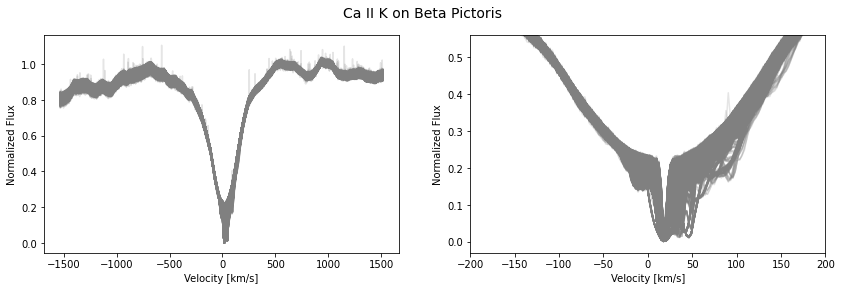

In [38]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

for i in range(a):
    # Construct the full path to the FITS file
    file_name=folder_path+'/'+resT[i]['adp_dpid']+'_TARGET_'+str(wave_range[0])+'-'+str(wave_range[1])+'.fits'

    # Check if the FITS file exists
    if os.path.exists(file_name): 
        hdulist = pyfits.open(file_name) # Open the FITS file
        scidata = hdulist[1].data # Bintable extension
        wave = scidata[0][0] # Wavelength data
        flux = scidata[0][1] # Flux data
        contw=[lammin,lammax]
        contf= flux[np.logical_and(wave > contw[0], wave < contw[1])] #Select fluxes within the wavelength range
        natwav=wave[np.logical_and(wave > contw[0], wave < contw[1])] # Select wavelengths within the range
        natf=contf/np.percentile(contf,95) # Normalize the flux
        flr = cg.downbin_spec(natf, natwav, wl, dlam=dwl) # Downsample the spectrum
        #print(f"flux {len(flux)} vs flr {len(flr)}")
        
        
        " Plot the normalized flux against wavelength "
        
        #ax[0].plot(wl,flr,c='grey',alpha=0.5)
        #ax[0].set_xlabel('Wavelength[A]')
        ax[0].plot(velocity,flr,c='grey',alpha=0.2)
        ax[0].set_xlabel('Velocity [km/s]')
        ax[0].set_ylabel('Normalized Flux')
        
        ax[1].plot(velocity,flr,c='grey',alpha=0.2)
        ax[1].set_xlabel('Velocity [km/s]')
        ax[1].set_ylabel('Normalized Flux')
        ax[1].set_xlim(-200,200)
        ax[1].set_ylim(-0.03,0.56)
        plt.suptitle('Ca II K on Beta Pictoris', fontsize=14)
        
        # For subsequent iterations (i > 0), add the new flux data to the existing DataFrame df.
        if i==0:
            # If this is the first iteration (i == 0), create a new DataFrame df to store the flux data.
            df=pd.DataFrame(data=flr, columns=[resT[i]['adp_dpid']])
            # Create another DataFrame df2 to store the observation date (MJD) of the file.
            df2=pd.DataFrame(data=[[resT[i]['adp_dpid'],hdulist[0].header['MJD-OBS']]],columns=['adp_dpid','MJD'])
            
            df3=pd.DataFrame(data=[[resT[i]['adp_dpid'],hdulist[0].header['DATE-OBS']]],columns=['adp_dpid','Date-Obs'])
        
        else:
            # For subsequent iterations (i > 0), add the new flux data to the existing DataFrame df.
            df[resT[i]['adp_dpid']]=flr
            
            # Add the new observation date to the existing DataFrame df2.
            df2.loc[i]=[resT[i]['adp_dpid'],hdulist[0].header['MJD-OBS']]

            df3.loc[i]=[resT[i]['adp_dpid'],hdulist[0].header['DATE-OBS']]
    # Print a message if the file is not found
    else:
        print(f'File not found: {file_name}')
adat=len(df)
df=df[:adat-1]
plt.savefig(folder_path+'/BetaPic.jpg', dpi=300,bbox_inches='tight')

In [75]:
print(df.shape)
print(df2.shape)
print(df3.shape)

(1170, 6676)
(6676, 2)
(6676, 2)


---

# Saving Data Frames as Pickle Files

---


In [69]:
df.to_pickle(parent_dir+'/my_notebooks/'+'df.pkl')  
df2.to_pickle(parent_dir+'/my_notebooks/'+'df2.pkl') 
df3.to_pickle(parent_dir+'/my_notebooks/'+'df3.pkl')  

To work with pickles

In [76]:
pk_df = pd.read_pickle(parent_dir+'/my_notebooks/'+'df.pkl')  
pk_df2 = pd.read_pickle(parent_dir+'/my_notebooks/'+'df2.pkl') 
pk_df3 = pd.read_pickle(parent_dir+'/my_notebooks/'+'df3.pkl')  

In [77]:
print(pk_df.shape)
print(pk_df2.shape)
print(pk_df3.shape)

(1170, 6676)
(6676, 2)
(6676, 2)


Saving wl and velocity files

In [14]:
np.savetxt('wl.txt', wl, fmt='%d')
np.savetxt('velocity.txt', wl, fmt='%d')